In [ ]:
from random import randint
from timeit import default_timer
size = 100
mat_1 = [[randint(0, size) for _ in range(size)] for _ in range(size)]
mat_2 = [[randint(0, size) for _ in range(size)] for _ in range(size)]
result = [[0 for _ in range(size)] for _ in range(size)]

### 1. Serial Implementation

In [ ]:
starttime = default_timer()

for i in range(size):
   for j in range(size):
       for k in range(size):
           result[i][j] += mat_1[i][k] * mat_2[k][j]

t1 = default_timer() - starttime
print("Serial Time Taken :", t1)
result = [[0 for _ in range(size)] for _ in range(size)]

Serial Time Taken : 0.4240078129998892


### 2. Data Parallel Implementation

In [ ]:
!pip install -q pymp-pypi
import pymp

starttime = default_timer()
res_arr = pymp.shared.array((size, size), dtype='uint8')
with pymp.Parallel(2) as p:
    for i in p.range(size):
      for j in range(size):
          for k in range(size):
              res_arr[i][j] += mat_1[i][k] * mat_2[k][j]

t2 = default_timer() - starttime
print("Parallel Time Taken :", t2)

Parallel Time Taken : 3.070237331000044


### 3. Numpy

In [ ]:
import numpy as np 

starttime = default_timer()

res = np.dot(mat_1,mat_2) 

t3 = default_timer() - starttime
print("Numpy Time Taken :", t3)

Numpy Time Taken : 0.004947687999901973


### 4. Scipy

In [ ]:
from scipy import sparse

m1 = sparse.csr_matrix(mat_1)
m2 = sparse.csr_matrix(mat_2)
starttime = default_timer()

res = m1.multiply(m2)

t4 = default_timer() - starttime
print("Scipy Time Taken :", t4)

Scipy Time Taken : 0.0029525400000238733


### 5. Pandas

In [ ]:
import numpy as np
import pandas as pd


df_1 = pd.DataFrame(mat_1)
df_2 = pd.DataFrame(mat_2)

starttime = default_timer()
df_1.dot(df_2)

t5 = default_timer() - starttime
print("Pandas Time Taken :", t5)

Pandas Time Taken : 0.0017128819999925327


### 6. Sympy

In [ ]:
from sympy import Matrix
m1 = Matrix(mat_1)
m2 = Matrix(mat_2)

starttime = default_timer()
r = m1*m2

t6 = default_timer() - starttime
print("Sympy Time Taken :", t6)

Sympy Time Taken : 9.038939131000006


### 7. Numba

In [ ]:
import numpy as np
import timeit
from numba import jit, float64, prange

@jit('float64[:,:](float64[:,:],float64[:,:])', parallel=True, nopython=True)
def matmul(A, B):
    C = np.zeros((A.shape[0], B.shape[1]))
    for i in prange(A.shape[0]):
        for j in prange(B.shape[1]):
            for k in range(A.shape[0]):
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
    return C

A = np.random.rand(size, size)
B = np.random.rand(size, size)

start = default_timer()

matmul(A, B)

t7 = default_timer() - start

print("Numba Time Taken :", t7) 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Numba Time Taken : 0.0013237749999461812


### 8. Linalg

In [ ]:
from numpy.linalg import multi_dot

start = default_timer()

_ = multi_dot([mat_1, mat_2])

t8 = default_timer() - start

print("linalg Time Taken :", t8) 

linalg Time Taken : 0.004973874999905092


### 9. Pymatrix

In [ ]:
!wget https://raw.githubusercontent.com/dthul/pymatrix/master/matrix.py
import sys
sys.path.append('/content/')

from matrix import Matrix
m1 = Matrix(mat_1)
m2 = Matrix(mat_2)

start = default_timer()

res = m1 * m2

t9 = default_timer() - start

print("pymatrix Time Taken :", t9) 

--2021-04-27 14:43:17--  https://raw.githubusercontent.com/dthul/pymatrix/master/matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16087 (16K) [text/plain]
Saving to: ‘matrix.py’

matrix.py           100%[===================>]  15.71K  --.-KB/s    in 0s      

2021-04-27 14:43:17 (111 MB/s) - ‘matrix.py’ saved [16087/16087]

pymatrix Time Taken : 0.34896002799996495


### 10. Tensorflow

In [ ]:
from tensorflow.linalg import matmul

start = default_timer()

_ = matmul(mat_1, mat_2)

t10 = default_timer() - start

print("tensorflow Time Taken :", t10) 

tensorflow Time Taken : 5.036223599000095


### 12. Pymc

In [ ]:
!pip install -q pymc3
import pymc3 as pm

start = default_timer()

res = pm.math.dot(mat_1, mat_2)
t12 = default_timer() - start

print("pymc Time Taken :", t12) 

pymc Time Taken : 0.006076633000020593


In [ ]:
import numpy as np
from functools import lru_cache, wraps
import numpy as np

def np_cache(*args, **kwargs):
    """LRU cache implementation for functions whose FIRST parameter is a numpy array
    >>> array = np.array([[1, 2, 3], [4, 5, 6]])
    >>> @np_cache(maxsize=256)
    ... def multiply(array, factor):
    ...     print("Calculating...")
    ...     return factor*array
    >>> multiply(array, 2)
    Calculating...
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply(array, 2)
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply.cache_info()
    CacheInfo(hits=1, misses=1, maxsize=256, currsize=1)
    
    """
    def decorator(function):
        @wraps(function)
        def wrapper(np_array, *args, **kwargs):
            hashable_array = array_to_tuple(np_array)
            return cached_wrapper(hashable_array, *args, **kwargs)

        @lru_cache(*args, **kwargs)
        def cached_wrapper(hashable_array, *args, **kwargs):
            array = np.array(hashable_array)
            return function(array, *args, **kwargs)

        def array_to_tuple(np_array):
            """Iterates recursivelly."""
            try:
                return tuple(array_to_tuple(_) for _ in np_array)
            except TypeError:
                return np_array

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear

        return wrapper

    return decorator

@np_cache(maxsize=256)
def sq_cache(array):
    return array*array
    
starttime = default_timer()

l1 = np.array(mat_1)

sq_cache(l1)

t13 = default_timer() - starttime
print("Custom Time Taken :", t13)

Custom Time Taken : 0.009742387999722268


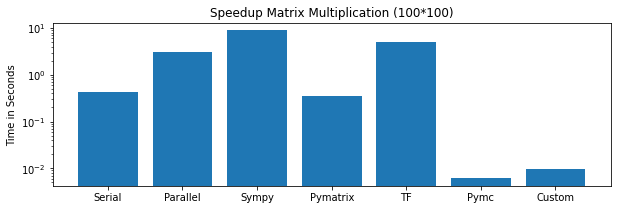

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


# methods = ['Serial','Parallel','Numpy','Scipy','Pandas','Sympy','Numba','Linalg','Pymatrix','TF','Pymc','Custom']
# times = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t12, t13]

methods = ['Serial','Parallel','Sympy','Pymatrix','TF','Pymc','Custom']
times = [t1, t2, t6, t9, t10, t12, t13]
ax.bar(methods,times)
ax.set_ylabel('Time in Seconds')
ax.set_title(f'Speedup Matrix Multiplication ({size}*{size})')

fig.set_size_inches(10, 3)

plt.yscale('log')
plt.show()